In [610]:
# from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.chrome.options import Options
import os
import json
import re
import datetime

from seleniumwire import webdriver  # Import from seleniumwire
driver = webdriver.Chrome()

chrm_options=Options()
chrm_caps = webdriver.DesiredCapabilities.CHROME.copy()
chrm_caps['goog:loggingPrefs'] = { 'performance':'ALL' } #save all returns including websocket data
driver = webdriver.Chrome(chrome_options=chrm_options,
                          desired_capabilities=chrm_caps) 

# options.add_argument("--disable-popup-blocking")
driver = webdriver.Chrome()

In [611]:
website = 'https://www.tradingview.com/'

In [613]:
driver.get(website)

In [614]:
query = driver.find_element_by_name('query')
query.send_keys('BTCN2019')
query.submit()

In [615]:
control = driver.find_element_by_id('header-toolbar-intervals')
control.click()

In [616]:
select_1h = driver.find_element_by_xpath("//div[@data-value='60']")
select_1h.click()

In [617]:
driver.refresh()
driver.switch_to_alert().accept()

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: use driver.switch_to.alert instead
  """


In [618]:
def wheel_element(element, deltaX = 0, deltaY = 120, offsetX = 0, offsetY = 0):
    error = element._parent.execute_script("""
    var element = arguments[0];
    var deltaX = arguments[1]
    var deltaY = arguments[2];
    var box = element.getBoundingClientRect();
    var clientX = box.left + (arguments[3] || box.width / 2);
    var clientY = box.top + (arguments[4] || box.height / 2);
    var target = element.ownerDocument.elementFromPoint(clientX, clientY);

    for (var e = target; e; e = e.parentElement) {
      if (e === element) {
        target.dispatchEvent(new MouseEvent('mouseover', {view: window, bubbles: true, cancelable: true, clientX: clientX, clientY: clientY}));
        target.dispatchEvent(new MouseEvent('mousemove', {view: window, bubbles: true, cancelable: true, clientX: clientX, clientY: clientY}));
        target.dispatchEvent(new WheelEvent('wheel',     {view: window, bubbles: true, cancelable: true, clientX: clientX, clientY: clientY, deltaX: deltaX, deltaY: deltaY}));
        return;
      }
    }    
    return "Element is not interactable";
    """, element, deltaX, deltaY, offsetY)
    if error:
        raise WebDriverException(error)

In [619]:
elm = driver.find_element_by_class_name('chart-gui-wrapper')

In [620]:
for i in range(100):
    wheel_element(elm, deltaX=0, deltaY=100)

for i in range(100):
    wheel_element(elm, deltaX=10, deltaY=0)

In [621]:
ws = []
for request in driver.requests:
    if request.ws_messages:
        ws.append(request.ws_messages)

In [699]:
messages = []
for w in ws:
    for l in w:
        m = l.content
        txt_list = re.split('~m~\d*~m~',m)       
        for t in txt_list:
            if len(t)<10:
                continue
            t = json.loads(t)
            try:
                if t['m'] == 'timescale_update':
                    messages.append(t)
            except:
                continue

In [647]:
messages_after_refresh = []
for m in messages:
    try:
        if m['m']=='timescale_update':
            messages_after_refresh.append(m) 
    except:
        continue

In [700]:
price_data = []

for m in messages:
    try:
        _j = m['p'][1]
        price_data.append([s['v']  for s in _j['sds_1']['s']])
    except:
        continue

In [701]:
import pandas as pd
df = [pd.DataFrame(p) for p in price_data]
df = pd.concat(df)

df.columns = ['Date', 'open', 'high', 'low', 'close', 'volume']
df.Date = pd.to_datetime(df.Date, unit='s')

In [702]:
print('before drop duplicate', len(df))
df = df.drop_duplicates('Date')
df.sort_values('Date', inplace=True)
print('after',len(df))
df.reset_index(inplace=True, drop=True)

before drop duplicate 1476
after 1126


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


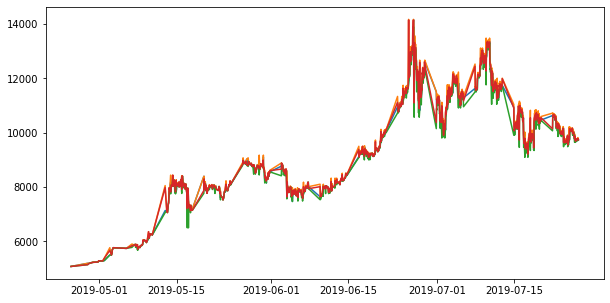

In [703]:
from matplotlib import pyplot as plt


plt.figure(figsize=(10,5))
plt.plot(df.Date, df.open)
plt.plot(df.Date, df.high)
plt.plot(df.Date, df.low)
plt.plot(df.Date, df.close)


In [704]:
df.tail(60)

,Date,open,high,low,close,volume
1066,2019-07-23 23:00:00,10040.0,10040.0,9805.0,9850.00,263.0
1067,2019-07-24 00:00:00,9830.0,9835.0,9615.0,9690.00,522.0
1068,2019-07-24 01:00:00,9705.0,9725.0,9660.0,9685.00,66.0
1069,2019-07-24 02:00:00,9680.0,9695.0,9590.0,9690.00,144.0
1070,2019-07-24 03:00:00,9680.0,9680.0,9610.0,9630.00,55.0
1071,2019-07-24 04:00:00,9625.0,9650.0,9560.0,9625.00,192.0
1072,2019-07-24 05:00:00,9610.0,9755.0,9600.0,9690.00,181.0
1073,2019-07-24 06:00:00,9685.0,9745.0,9670.0,9670.00,17.0
1074,2019-07-24 07:00:00,9680.0,9710.0,9650.0,9665.00,23.0
1075,2019-07-24 08:00:00,9700.0,9775.0,9700.0,9730.00,23.0
